<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Ali Mohseninejad
### Student ID: 402210195

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 135469013.71it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 104517423.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51523079.19it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20752209.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

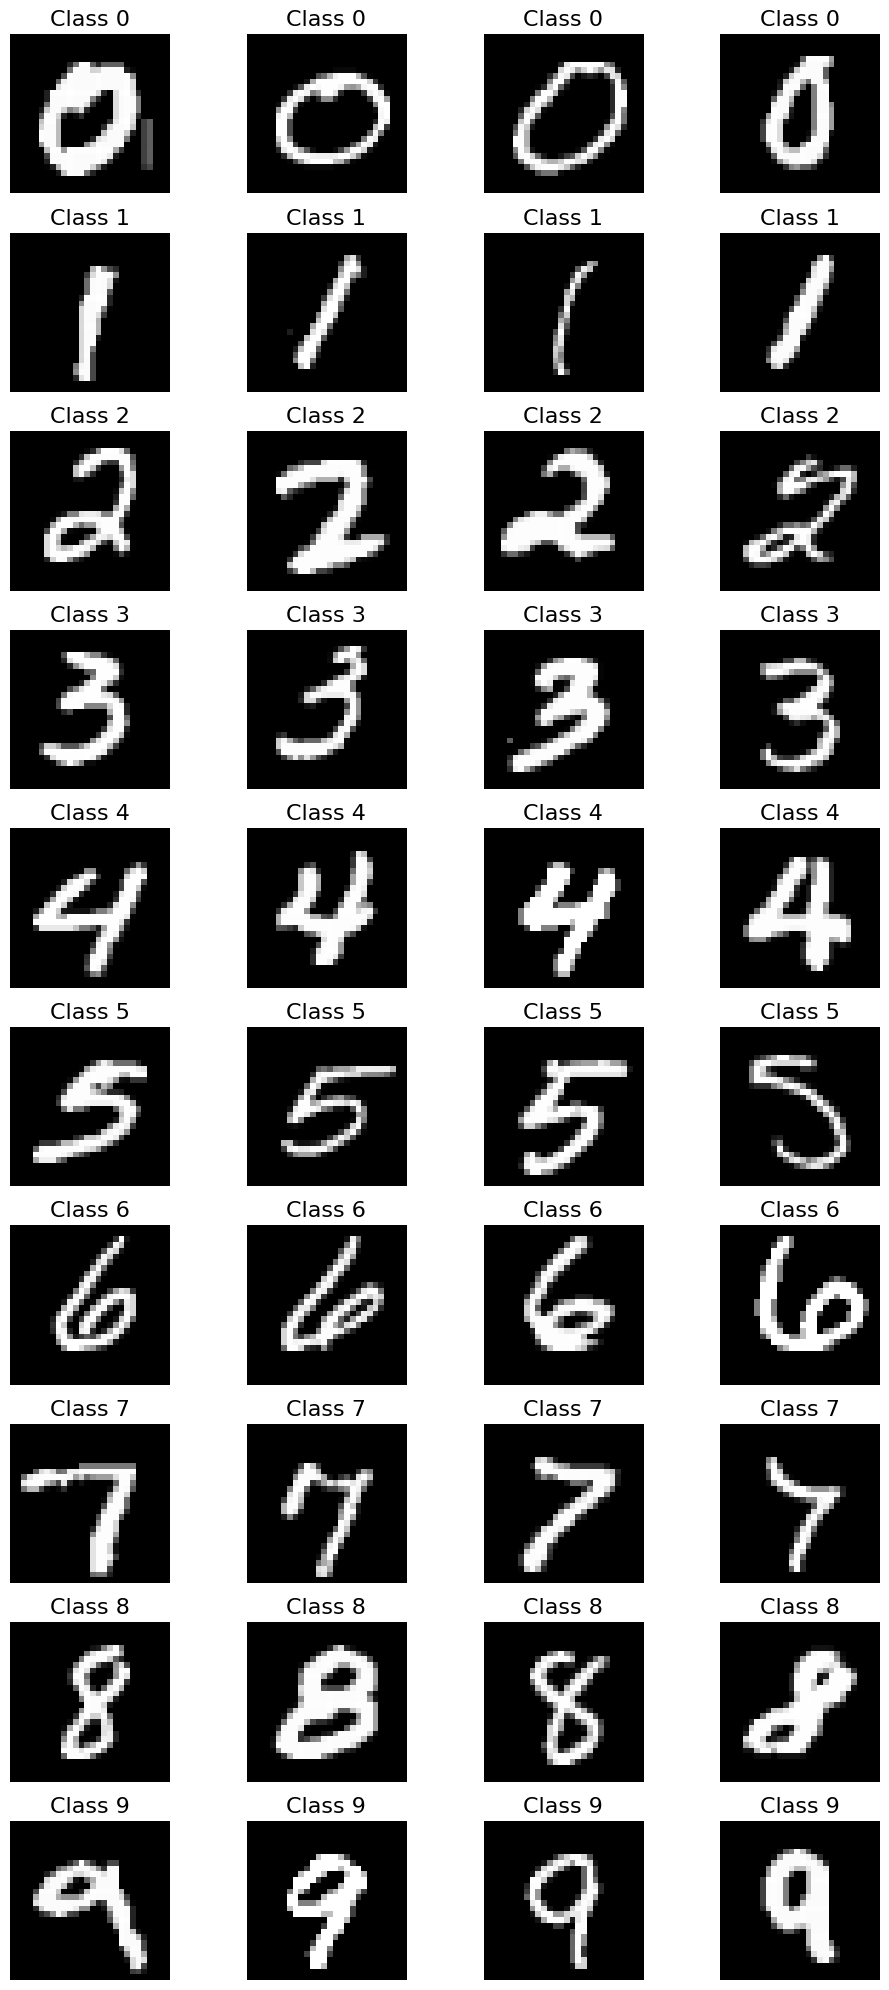

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [11]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(std.device)
        return mu + eps * std

    def forward(self, x):
        # Encode
        enc_output = self.encoder(x)
        mu, logvar = torch.chunk(enc_output, 2, dim=-1)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        dec_output = self.decoder(z)

        return dec_output, mu, logvar


In [12]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = reconstruction_loss + kl_divergence

    return total_loss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):

            optimizer.zero_grad()

            # TODO: Flatten the data and recon tensors
            data = data.view(data.shape[0], -1).to(device)
            recon, mu, logvar = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (len(train_loader)*data.shape[0]*data.shape[1])
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict() # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, f'/content/drive/MyDrive/DeepHW/ProblemSet4/best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 0.4537807631381607
Sample Images:


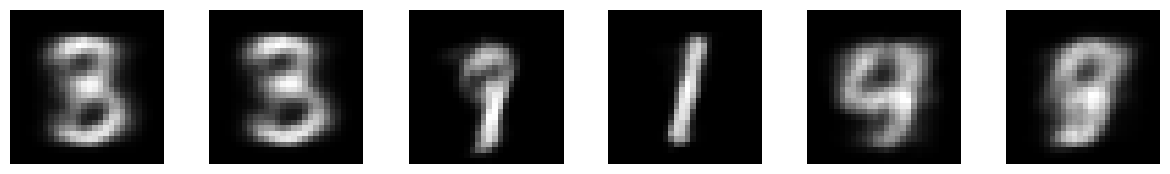


##################################################
VAE-MLP Epoch [2/10], Loss: 0.4016922564021207
Sample Images:


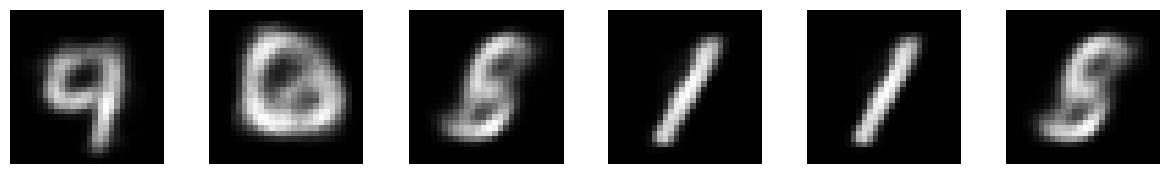


##################################################
VAE-MLP Epoch [3/10], Loss: 0.39037230857114436
Sample Images:


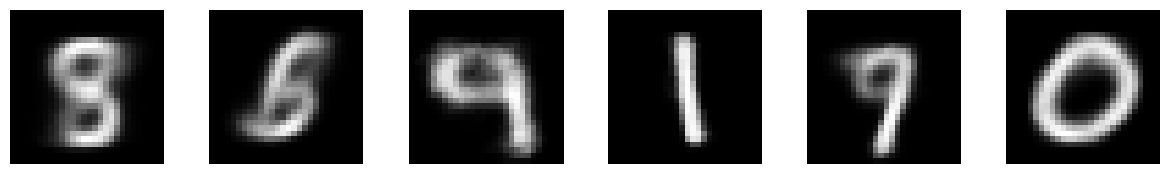


##################################################
VAE-MLP Epoch [4/10], Loss: 0.3836651269597249
Sample Images:


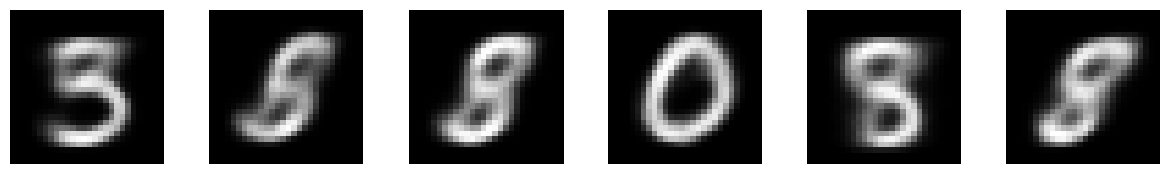


##################################################
VAE-MLP Epoch [5/10], Loss: 0.37937459310338484
Sample Images:


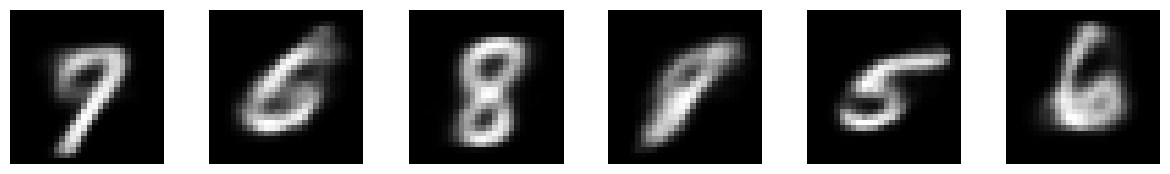


##################################################
VAE-MLP Epoch [6/10], Loss: 0.3757226670578386
Sample Images:


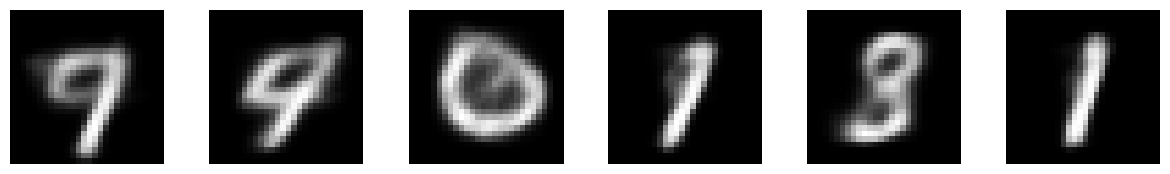


##################################################
VAE-MLP Epoch [7/10], Loss: 0.37303971298099586
Sample Images:


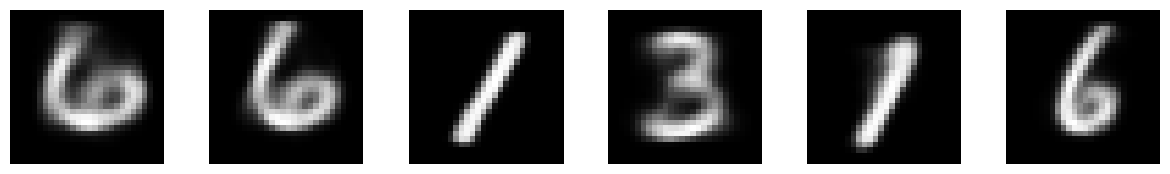


##################################################
VAE-MLP Epoch [8/10], Loss: 0.37046007995718344
Sample Images:


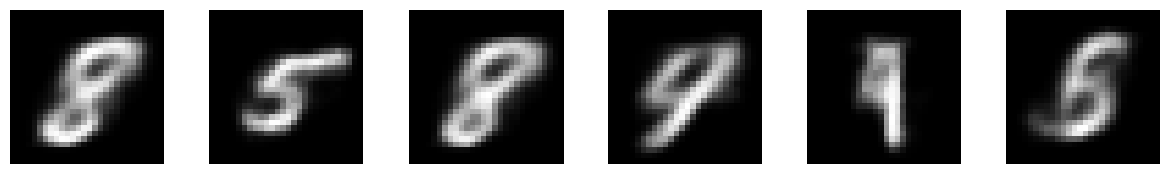


##################################################
VAE-MLP Epoch [9/10], Loss: 0.368620813009628
Sample Images:


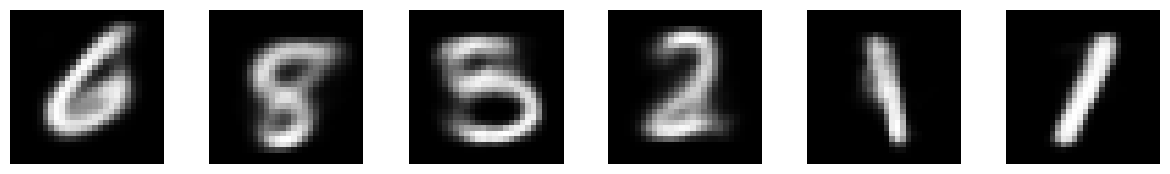


##################################################
VAE-MLP Epoch [10/10], Loss: 0.3669109406003773
Sample Images:


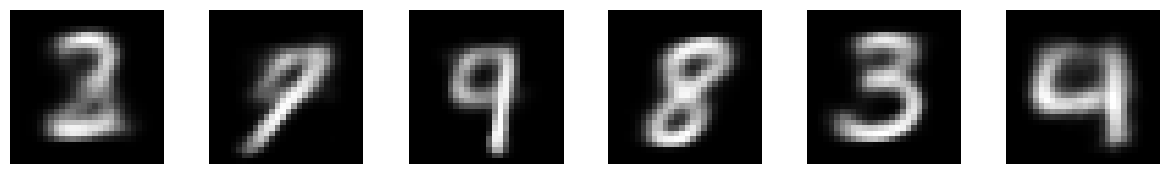

Best model saved as 'best_vae_mlp_model.pth'


In [20]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [21]:
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2 + num_classes)
        )

        self.fc_mu = None
        self.fc_logvar = None
        self.fc_class = None

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(std.device)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        xy = torch.cat((x, y), dim=1)

        enc_output = self.encoder(xy)
        mu, logvar = torch.chunk(enc_output[:, :self.latent_dim * 2], 2, dim=-1)
        class_logits = enc_output[:, -self.num_classes:]

        z = self.reparameterize(mu, logvar)

        zy = torch.cat((z, y), dim=1)
        reconstructed = self.decoder(zy)

        return reconstructed, mu, logvar, class_logits



In [46]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.shape[0], -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


In [47]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = torch.zeros((labels.shape[0], 10)).to(device)
            for ii, item in enumerate(labels):
                labels_one_hot[ii][item] = 1

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            data = data.view(data.shape[0], -1).to(device)
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels_one_hot)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()


        avg_loss = total_loss/(len(train_loader)*data.shape[0]*data.shape[1])
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1).to(device)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, f'/content/drive/MyDrive/DeepHW/ProblemSet4/best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 0.41427517592930296
Sample Images:


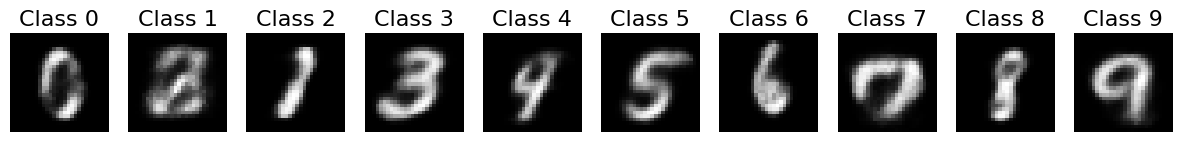


##################################################
CVAE-MLP Epoch [2/10], Loss: 0.3539011294689986
Sample Images:


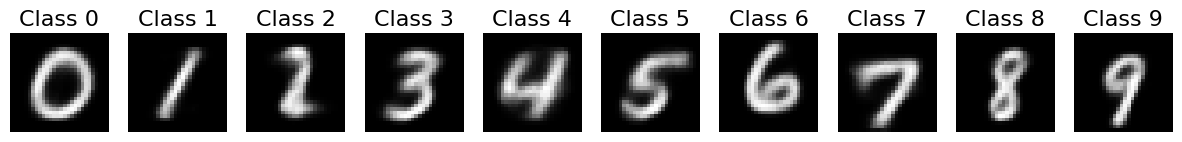


##################################################
CVAE-MLP Epoch [3/10], Loss: 0.3449482179736921
Sample Images:


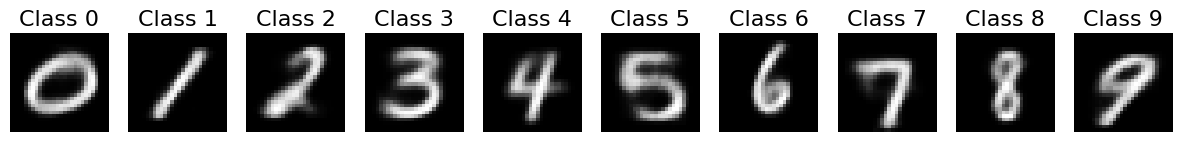


##################################################
CVAE-MLP Epoch [4/10], Loss: 0.34067514581689845
Sample Images:


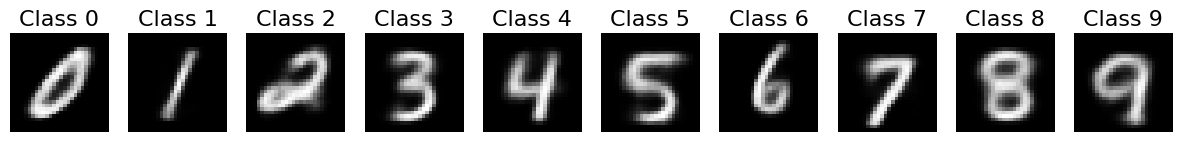


##################################################
CVAE-MLP Epoch [5/10], Loss: 0.3378500932398262
Sample Images:


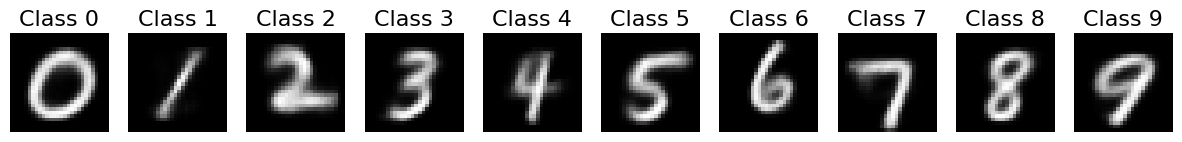


##################################################
CVAE-MLP Epoch [6/10], Loss: 0.3361011686433384
Sample Images:


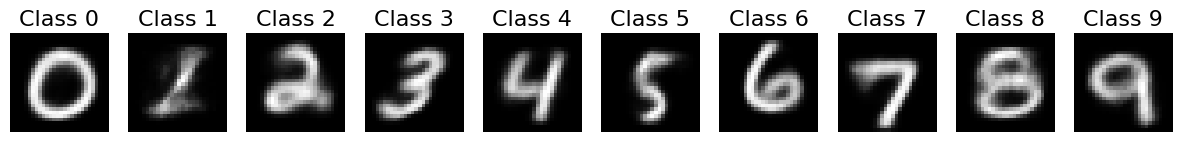


##################################################
CVAE-MLP Epoch [7/10], Loss: 0.33457022952813503
Sample Images:


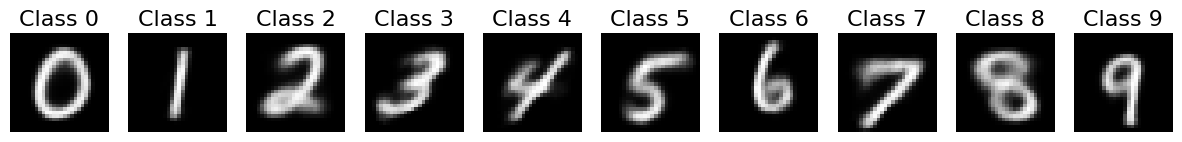


##################################################
CVAE-MLP Epoch [8/10], Loss: 0.33333736159856364
Sample Images:


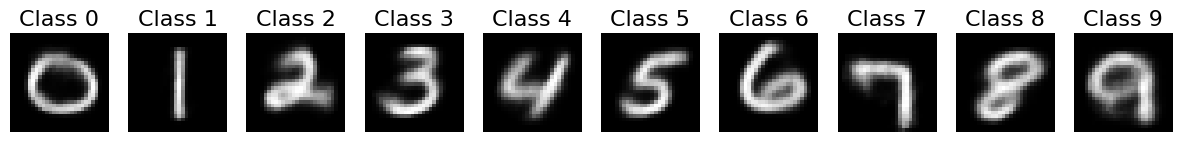


##################################################
CVAE-MLP Epoch [9/10], Loss: 0.33226215888665317
Sample Images:


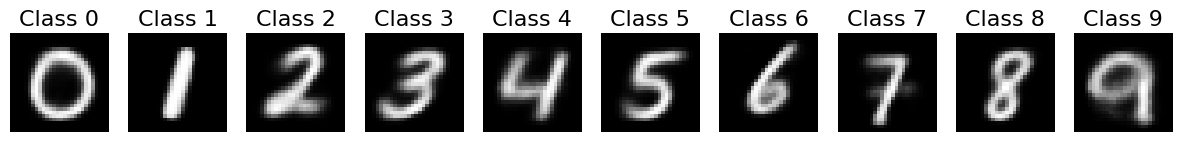


##################################################
CVAE-MLP Epoch [10/10], Loss: 0.331277000660799
Sample Images:


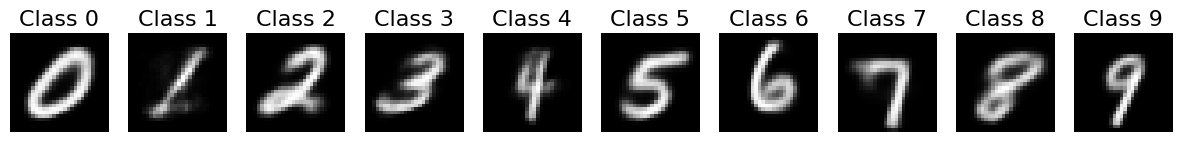

Best model saved as 'best_cvae_mlp_model.pth'


In [48]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


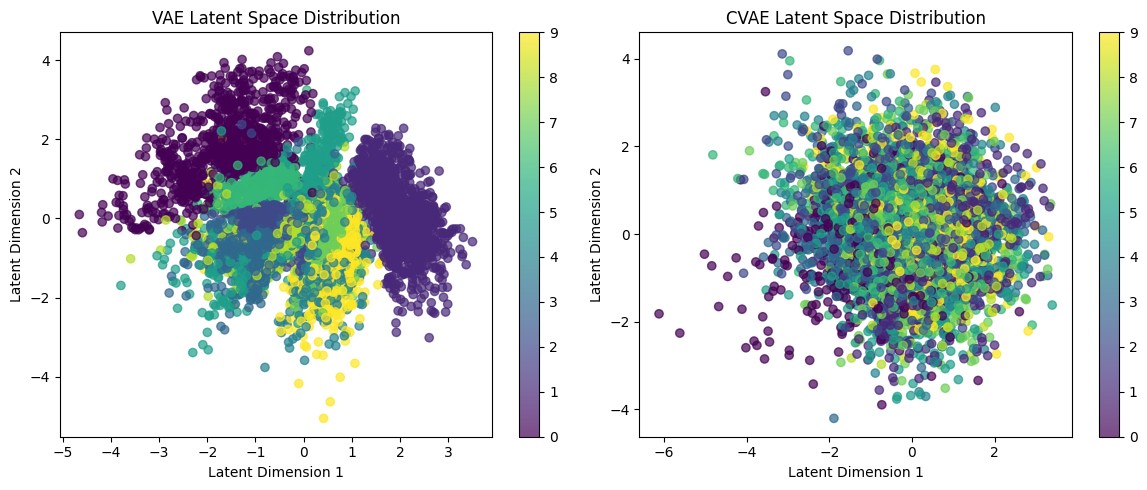

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae_model = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)
vae_model.load_state_dict(torch.load(f'/content/drive/MyDrive/DeepHW/ProblemSet4/best_vae_mlp_model.pth'))
vae_model.to(device)
vae_model.eval()

cvae_model = CVAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2, num_classes=10)
cvae_model.load_state_dict(torch.load(f'/content/drive/MyDrive/DeepHW/ProblemSet4/best_cvae_mlp_model.pth'))
cvae_model.to(device)
cvae_model.eval()

def get_latent_representation(model, data_loader, device):
    latent_space = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.view(batch_data.shape[0], -1).to(device)
            if isinstance(model, VAE_MLP):
                _, mu, _ = model(batch_data)
            else:
                labels_one_hot = torch.zeros((batch_labels.shape[0], 10)).to(device)
                for ii, item in enumerate(batch_labels):
                    labels_one_hot[ii][item] = 1
                _, mu, _, _ = model(batch_data, labels_one_hot)
            latent_space.append(mu.cpu())
            labels.append(batch_labels.cpu())

    latent_space = torch.cat(latent_space, dim=0)
    labels = torch.cat(labels, dim=0)

    return latent_space, labels

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Get latent space representations for both models
vae_latent_space, vae_labels = get_latent_representation(vae_model, test_loader, device)
cvae_latent_space, cvae_labels = get_latent_representation(cvae_model, test_loader, device)

# Visualize latent space distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(vae_latent_space[:, 0], vae_latent_space[:, 1], c=vae_labels, cmap='viridis', alpha=0.7)
plt.title('VAE Latent Space Distribution')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(cvae_latent_space[:, 0], cvae_latent_space[:, 1], c=cvae_labels, cmap='viridis', alpha=0.7)
plt.title('CVAE Latent Space Distribution')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar()

plt.tight_layout()
plt.show()


As we can see in the above figures, the VAE model has clustered the latent space into 10 clusters which are spacially seperable. But the CVAE latent space didn't seperate the data points in the latent space. This is all because of the Condition in CVAE. The difference between different classes is not embedded in the latent space but it is in the condition that is given to it. That is why it has mixed latent space.